# Kuzushiji-MNIST
## Classify handwritten characters in ancient Japanese manuscripts
Kuzushiji, a Japanese script used for more than 1,000 years, lacked a common standard and sometimes contained dozens of different styles and formats for the same word. in the 19th century, Japan reformed and standardized its official language and writing system. Eventually the Kuzushiji script became extinct and millions of documents about Japanese culture and history became inaccessible to most people.

### CITATION
Tarin Clanuwat, Mikel Bober-Irizar, Asanobu Kitamoto, Alex Lamb, Kazuaki Yamamoto, David Ha, "Deep Learning for Classical Japanese Literature", arXiv:1812.01718.

### LICENSE OF DATASET
"KMNIST Dataset" (created by CODH), adapted from "Kuzushiji Dataset" (created by NIJL and others), doi:10.20676/00000341

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics, manifold, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
import seaborn as sns
import collections

### The dataset
Kuzushiji-MNIST is a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images). Since MNIST restricts us to 10 classes, we chose one character to represent each of the 10 rows of Hiragana when creating Kuzushiji-MNIST.

In [2]:
train_images = np.load('./Kuzushiji-MNIST/kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('./Kuzushiji-MNIST/kmnist-train-labels.npz')['arr_0']
test_images = np.load('./Kuzushiji-MNIST/kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('./Kuzushiji-MNIST/kmnist-test-labels.npz')['arr_0']

label_map = pd.read_csv('./Kuzushiji-MNIST/kmnist_classmap.csv')['char']
print(label_map)

0    お
1    き
2    す
3    つ
4    な
5    は
6    ま
7    や
8    れ
9    を
Name: char, dtype: object


###  Image of training data per class

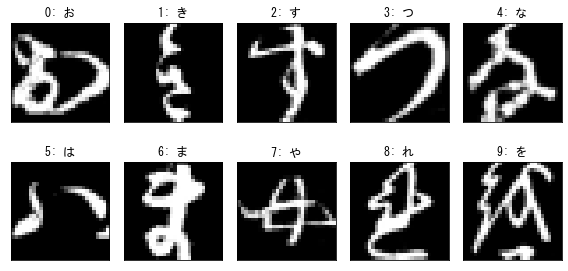

In [3]:
plt.figure(figsize=(8, 6))
label_cnt=0
for i in range(10):
    plt.subplot(3, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    while train_labels[label_cnt]!=i:
        label_cnt+=1
    plt.imshow(train_images[label_cnt], cmap='gray')
    #plt.title(train_labels[label_cnt])
    plt.title("{}: ".format(train_labels[label_cnt])+label_map[train_labels[label_cnt]], fontname="MS Gothic")
    
plt.tight_layout()
plt.show()

### Data size

In [4]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [5]:
count_dict = collections.Counter(train_labels)
print(count_dict)

Counter({8: 6000, 7: 6000, 0: 6000, 1: 6000, 4: 6000, 2: 6000, 5: 6000, 6: 6000, 9: 6000, 3: 6000})


C:\Users\umeco\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


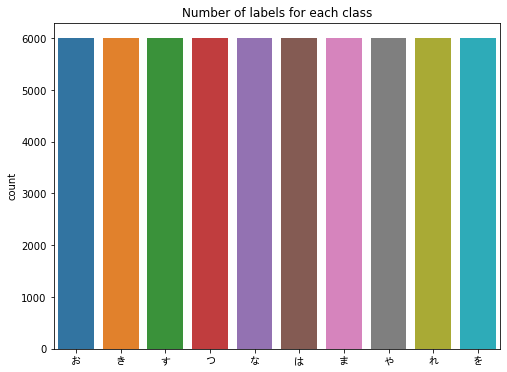

In [6]:
f, ax = plt.subplots(1,1, figsize=(8,6))
g = sns.countplot(train_labels)
g.set_title("Number of labels for each class")
g.set_xticklabels(label_map, fontname="MS Gothic")
plt.show() 

###  Average image of training data per class

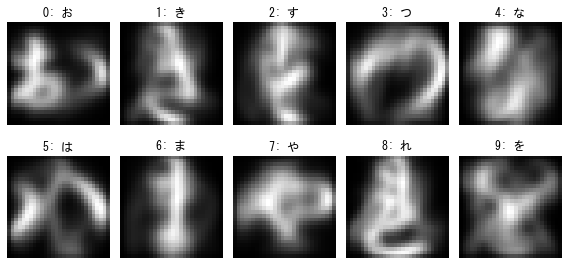

In [7]:
plt.figure(figsize=(8, 4))

for label in range(10):
    plt.subplot(2, 5, label + 1)
    indices = np.where(train_labels == label)
    mean_image = train_images[indices].mean(axis=0)
    plt.imshow(mean_image, cmap='gray')
    #plt.title(label)
    plt.title("{}: ".format(label)+label_map[label], fontname="MS Gothic")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

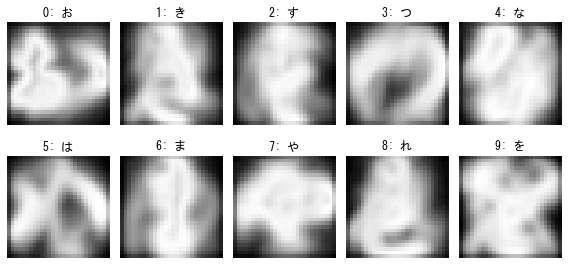

In [8]:
plt.figure(figsize=(8, 4))

for label in range(10):
    plt.subplot(2, 5, label + 1)
    indices = np.where(train_labels == label)
    mean_image = train_images[indices].std(axis=0)
    plt.imshow(mean_image, cmap='gray')
    #plt.title(label)
    plt.title("{}: ".format(label)+label_map[label], fontname="MS Gothic")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

### Data scaling

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

### Visualize the dataset using T-SNE

In [10]:
train_sample_size = 5000
idx = np.random.choice(60000, size=train_sample_size, replace=False)
train_sample = train_images.reshape(60000, -1)[idx, :]

In [11]:
test_sample_size = 1000
test_idx = np.random.choice(10000, size=test_sample_size, replace=False)
test_sample = test_images.reshape(10000, -1)[test_idx, :]

In [12]:
train_sample.shape

(5000, 784)

In [13]:
test_sample.shape

(1000, 784)

In [14]:
# Generate 2D embedding with TSNE
embeddings = manifold.TSNE().fit_transform(train_sample)

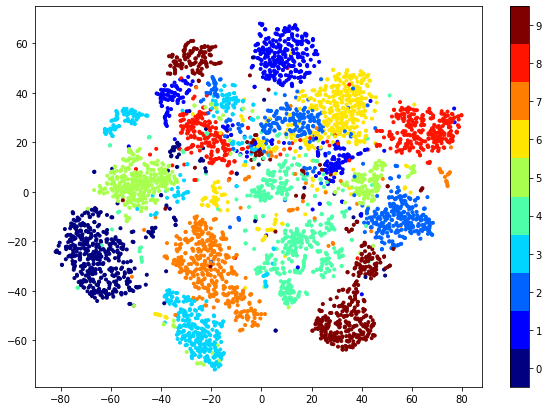

In [15]:
# Visualize TSNE embedding
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

plt.figure(figsize=(10,7))
plt.scatter(vis_x, vis_y, c=train_labels[idx], cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

### EDA

In [16]:
# dedcution of data demension by PCA
pca = decomposition.PCA(n_components=784)
pca.fit(train_sample)

PCA(n_components=784)

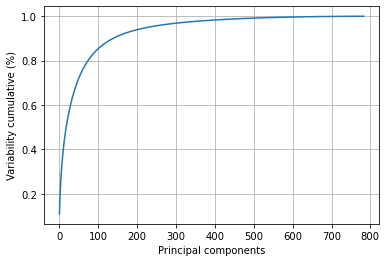

In [17]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal components')
plt.ylabel('Variability cumulative (%)')
plt.grid();

In [18]:
pca = decomposition.PCA(n_components=300)
pca.fit(train_sample)

PCA(n_components=300)

In [19]:
new_train_images = pca.transform(train_sample)
new_test_images = pca.transform(test_sample)

In [20]:
new_train_images.shape

(5000, 300)

In [21]:
new_test_images.shape

(1000, 300)

###  k-NN as baseline

In [22]:
clf_knn = KNeighborsClassifier(n_jobs=6)
clf_knn.fit(train_sample, train_labels[idx])

KNeighborsClassifier(n_jobs=6)

In [23]:
y_pred = clf_knn.predict(test_sample)

In [24]:
print(metrics.accuracy_score(test_labels[test_idx], y_pred))

0.796


In [25]:
print(metrics.classification_report(test_labels[test_idx], y_pred))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81        83
           1       0.78      0.90      0.83       108
           2       0.68      0.77      0.72       111
           3       0.70      0.90      0.79        98
           4       0.88      0.71      0.78        95
           5       0.83      0.83      0.83       104
           6       0.81      0.86      0.84        96
           7       0.97      0.65      0.78       101
           8       0.68      0.80      0.73        99
           9       0.95      0.78      0.86       105

    accuracy                           0.80      1000
   macro avg       0.82      0.79      0.80      1000
weighted avg       0.81      0.80      0.80      1000



###  k-NN as baseline with  the dimensional reduction data 

In [26]:
clf_knn = KNeighborsClassifier(n_jobs=6)
clf_knn.fit(new_train_images, train_labels[idx])

KNeighborsClassifier(n_jobs=6)

In [27]:
y_pred = clf_knn.predict(new_test_images)

In [28]:
print(metrics.accuracy_score(test_labels[test_idx], y_pred))

0.809


In [29]:
print(metrics.classification_report(test_labels[test_idx], y_pred))

              precision    recall  f1-score   support

           0       0.86      0.77      0.82        83
           1       0.78      0.93      0.84       108
           2       0.71      0.81      0.76       111
           3       0.75      0.90      0.81        98
           4       0.89      0.68      0.77        95
           5       0.84      0.82      0.83       104
           6       0.82      0.88      0.85        96
           7       0.97      0.68      0.80       101
           8       0.70      0.83      0.76        99
           9       0.93      0.78      0.85       105

    accuracy                           0.81      1000
   macro avg       0.83      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000



### Select the best classifier

In [30]:
clf_names = ['LinearSVC','AdaBoostClassifier','ExtraTreesClassifier' , 'RandomForestClassifier', 'KNeighborsClassifier',
             'Linear SVM', 'RBF SVM', 'Decision Tree',  'Naive Bayes', 'LDA', 'QDA']

classifiers = [LinearSVC(), AdaBoostClassifier(), ExtraTreesClassifier(), RandomForestClassifier(), KNeighborsClassifier(),
               SVC(kernel='linear'), SVC(kernel='rbf'), DecisionTreeClassifier(),
               GaussianNB(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()]


X = new_train_images
#y = train_labels
y = train_labels[idx]

print("data size", new_train_images.shape)

data size (5000, 300)


In [31]:
i=0
for clf in classifiers:
    scores = cross_validate(clf, X, y, cv=5, n_jobs=6)
    #print(scores)
    score  = np.mean(scores["test_score"])
    print("{} : {}".format(clf_names[i], score))
    i+=1

Score of LinearSVC : 0.7303999999999998
Score of AdaBoostClassifier : 0.4974
Score of ExtraTreesClassifier : 0.8038000000000001
Score of RandomForestClassifier : 0.8164
Score of KNeighborsClassifier : 0.8942
Score of Linear SVM : 0.7948000000000001
Score of RBF SVM : 0.9036000000000002
Score of Decision Tree : 0.6346
Score of Naive Bayes : 0.6824000000000001
Score of LDA : 0.7293999999999999
Score of QDA : 0.7087999999999999


In [32]:
svc = SVC(kernel='rbf')
C_s = np.logspace(-3, 3, 10)

scores = list()
for C in C_s:
    svc.C = C
    this_scores = cross_validate(svc, X, y, cv=5, n_jobs=6)
    scores.append(np.mean(this_scores["test_score"]))
    print(C)

0.001
0.004641588833612777
0.021544346900318832
0.1
0.46415888336127775
2.154434690031882
10.0
46.41588833612773
215.44346900318823
1000.0


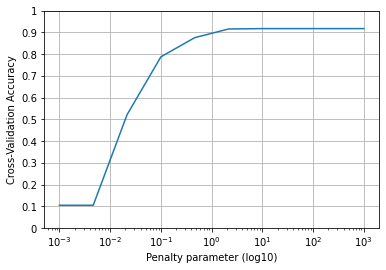

In [33]:
plt.clf()
plt.semilogx(C_s, scores)
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('Cross-Validation Accuracy')
plt.xlabel('Penalty parameter (log10)')
plt.grid()
plt.show()

In [34]:
selected_C=10

svc = SVC(kernel='rbf', C=selected_C)
gamma_s = np.linspace(0.005, 0.03, 10)

scores_2 = list()
for gm in gamma_s:
    svc.gamma = gm
    this_scores = cross_validate(svc, X, y, cv=5, n_jobs=6)
    scores_2.append(np.mean(this_scores["test_score"]))
    print(gm)


0.005
0.0077777777777777776
0.010555555555555554
0.013333333333333332
0.01611111111111111
0.01888888888888889
0.021666666666666664
0.024444444444444442
0.02722222222222222
0.03


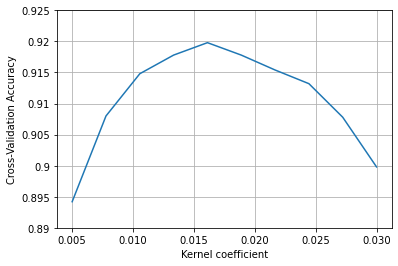

In [35]:
plt.clf()
#semilogx(C_s, scores)
plt.plot(gamma_s, scores_2)
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('Cross-Validation Accuracy')
plt.xlabel('Kernel coefficient')
plt.grid()
plt.show()

### Choose the best model

In [36]:
classifier = SVC(kernel='rbf')
FS = decomposition.PCA()
pipe = Pipeline([('feature_selection', FS),('classification', classifier)], n_jobs=6)

# parameter list
n_components = [200, 300, 400, 500]
Cs = [1, 10, 100]
gammas = [0.010, 0.015, 0.02]

In [37]:
estimator = GridSearchCV(pipe,
                         dict(feature_selection__n_components = n_components,
                              classification__C = Cs,
                              classification__gamma = gammas
                             )
                         )

In [38]:
estimator.fit(train_sample, y)

GridSearchCV(estimator=Pipeline(steps=[('feature_selection', PCA()),
                                       ('classification', SVC())]),
             param_grid={'classification__C': [1, 10, 100],
                         'classification__gamma': [0.01, 0.015, 0.02],
                         'feature_selection__n_components': [200, 300, 400,
                                                             500]})

In [39]:
estimator.best_estimator_.named_steps['feature_selection'].n_components

200

In [40]:
estimator.best_estimator_.named_steps['classification'].C

100

In [41]:
estimator.best_estimator_.named_steps['classification'].gamma

0.02

In [42]:
estimator.best_score_ 

0.9199999999999999

## One vs One or  One vs Reat

In [46]:
fs = decomposition.PCA(n_components=200)
cls = SVC(kernel='rbf', C=100, gamma=0.015)

pipe1 = Pipeline([('feature_selection', fs),
        ('classification', OneVsOneClassifier(cls))])

pipe2 = Pipeline([('feature_selection', fs),
        ('classification', OneVsRestClassifier(cls))])

In [47]:
pipe1.fit(train_sample, y)

Pipeline(steps=[('feature_selection', PCA(n_components=200)),
                ('classification',
                 OneVsOneClassifier(estimator=SVC(C=100, gamma=0.015)))])

In [48]:
pipe2.fit(train_sample, y)

Pipeline(steps=[('feature_selection', PCA(n_components=200)),
                ('classification',
                 OneVsRestClassifier(estimator=SVC(C=100, gamma=0.015)))])

In [49]:
predicted1 = pipe1.predict(test_sample)

In [51]:
print(metrics.accuracy_score(test_labels[test_idx], predicted1))

0.851


In [50]:
predicted2 = pipe2.predict(test_sample)

In [52]:
print(metrics.accuracy_score(test_labels[test_idx], predicted2))

0.859


### Apply my final model

In [10]:
fs = decomposition.PCA(n_components=200)

In [11]:
fs.fit(train_images.reshape(-1, 784))

PCA(n_components=200)

In [12]:
new_train_images = fs.transform(train_images.reshape(-1, 784))
new_test_images = fs.transform(test_images.reshape(-1, 784))

In [13]:
cls = OneVsRestClassifier(SVC(kernel='rbf', C=100, gamma=0.015))

In [14]:
cls.fit(new_train_images, train_labels)

OneVsRestClassifier(estimator=SVC(C=100, gamma=0.015))

In [15]:
predicted_train = cls.predict(new_train_images)

In [16]:
predicted_test = cls.predict(new_test_images)

In [17]:
print(metrics.accuracy_score(train_labels, predicted_train))
print(metrics.accuracy_score(test_labels, predicted_test))

0.99975
0.9417


In [18]:
print(metrics.classification_report(train_labels, predicted_train))
print(metrics.classification_report(test_labels, predicted_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6000
           1       1.00      1.00      1.00      6000
           2       1.00      1.00      1.00      6000
           3       1.00      1.00      1.00      6000
           4       1.00      1.00      1.00      6000
           5       1.00      1.00      1.00      6000
           6       1.00      1.00      1.00      6000
           7       1.00      1.00      1.00      6000
           8       1.00      1.00      1.00      6000
           9       1.00      1.00      1.00      6000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1000
           1       0.96      0.93      0.94      1000
           2       0.89      0.89      0.89      1000
           3       0.92 

In [19]:
print(metrics.confusion_matrix(train_labels, predicted_train))
print(metrics.confusion_matrix(test_labels, predicted_test))

[[5993    0    0    7    0    0    0    0    0    0]
 [   0 6000    0    0    0    0    0    0    0    0]
 [   0    0 5998    2    0    0    0    0    0    0]
 [   0    0    0 6000    0    0    0    0    0    0]
 [   0    0    0    0 6000    0    0    0    0    0]
 [   0    0    0    2    0 5998    0    0    0    0]
 [   0    0    0    0    0    0 6000    0    0    0]
 [   0    0    0    2    0    0    0 5998    0    0]
 [   0    0    0    1    0    0    0    0 5999    0]
 [   0    0    0    1    0    0    0    0    0 5999]]
[[956   3   2   1  13   5   2   9   8   1]
 [  2 934   6   1   6   3  32   6   6   4]
 [  7   6 893  46   8   6  11   7  11   5]
 [  1   2  13 975   1   3   1   1   2   1]
 [ 20  11   3   8 924   1  10   4  14   5]
 [  3   8  41   6   4 915  16   2   0   5]
 [  3   2  14   7   9   1 959   2   2   1]
 [  7   1   9   1   4   2   8 950  12   6]
 [  2   8   4   9   3   2   7   1 963   1]
 [  4   3  14   7   5   0   2   4  13 948]]


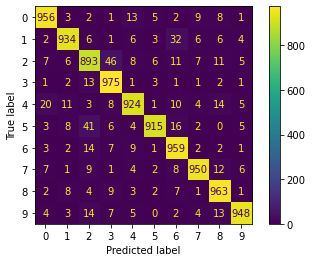

In [31]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(test_labels, predicted_test), 
                                      display_labels=cls.classes_)

disp.plot()
plt.show()

### Analysis of the result

In [20]:
correct = np.nonzero(predicted_test==test_labels)[0]
incorrect = np.nonzero(predicted_test!=test_labels)[0]

In [21]:
print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

Correct predicted classes: 9417
Incorrect predicted classes: 583


In [27]:
def plot_images(data_index):
    # Plot the sample images now
    f, ax = plt.subplots(5,5, figsize=(12,12))

    for i, indx in enumerate(data_index[:25]):
        ax[i//5, i%5].imshow(test_images[indx].reshape(28, 28), cmap="gray")
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("True:{}  Pred:{}".format(test_labels[indx], predicted_test[indx]))
        plt.axis('off')
    plt.show()    

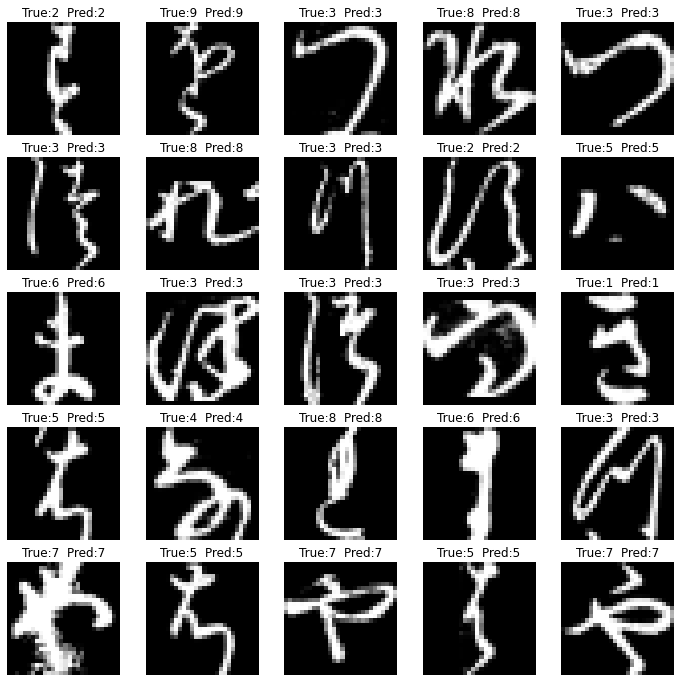

In [26]:
plot_images(correct)

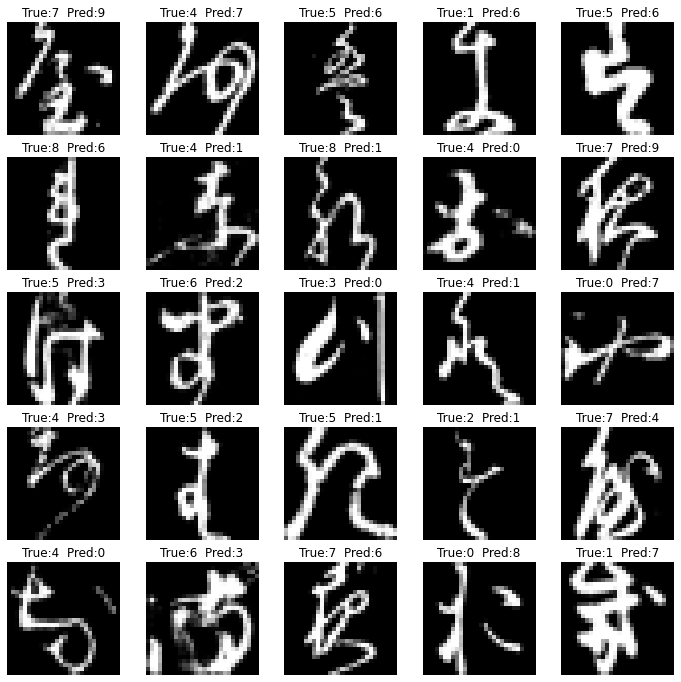

In [28]:
plot_images(incorrect)